In [246]:
# Importing required libraries

# Keras
import keras
from keras import regularizers
from keras_preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences
from keras import Sequential, Model
from keras._tf_keras.keras.models import model_from_json
from keras._tf_keras.keras.layers import Dense, Embedding, LSTM, Input, Flatten, Dropout, Activation, \
    BatchNormalization, Conv1D, MaxPooling1D, AveragePooling1D
from keras._tf_keras.keras.utils import to_categorical
from keras._tf_keras.keras.callbacks import ModelCheckpoint
from keras._tf_keras.keras import utils
from keras._tf_keras.keras import optimizers
import np_utils

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other
# import librosa.display
import json
from scipy.io import wavfile
from python_speech_features import mfcc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob
import os
import pickle
import IPython.display as ipd  # To play sound in the notebook

import sys
import warnings



In [247]:
# Filter specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="librosa.core.audio")

# ignore general warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [248]:
# let's pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv(r"C:\Users\eo19181\Documents\All -  Datasets\data_paths.csv")
print(ref.head())


       labels           source  \
0  female_ang  CREMA - Dataset   
1  female_ang  CREMA - Dataset   
2  female_ang  CREMA - Dataset   
3  female_ang  CREMA - Dataset   
4  female_ang  CREMA - Dataset   

                                                path  
0  C:\Users\eo19181\Documents\All -  Datasets\CRE...  
1  C:\Users\eo19181\Documents\All -  Datasets\CRE...  
2  C:\Users\eo19181\Documents\All -  Datasets\CRE...  
3  C:\Users\eo19181\Documents\All -  Datasets\CRE...  
4  C:\Users\eo19181\Documents\All -  Datasets\CRE...  


In [249]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
# Iterate over audio file paths and extract MFCCs
for index, path in enumerate(ref.path):
    # Read audio file
    sample_rate, X = wavfile.read(path)

    # Extract MFCCs (returns an array)
    mfccs = mfcc(X, samplerate=sample_rate, numcep=600, nfft=2048)

    # Compute mean of MFCCs across time
    mfccs_mean = np.mean(mfccs, axis=0)

    # Store in DataFrame
    df.loc[index] = [mfccs_mean]

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

26862


,feature
0,"[16.07999344600187, -14.148828811421287, -6.78..."
1,"[14.046210604183573, -5.986710636224169, -0.11..."
2,"[14.76273863495432, -6.623625075443414, -3.565..."
3,"[14.636657186849847, -6.657819683515079, -1.65..."
4,"[15.932731610677642, -9.300448623838454, -4.28..."


In [250]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df[:5]

,labels,source,path,0,1,2,3,4,5,6,...,16,17,18,19,20,21,22,23,24,25
0,female_ang,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,16.079993,-14.148829,-6.780754,0.320910,-1.705636,-6.932662,-7.320016,...,-0.173808,-3.736864,-1.799825,-0.132324,0.840623,0.429823,-0.087040,0.062754,-0.075532,-0.418402
1,female_ang,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,14.046211,-5.986711,-0.118964,-2.075361,-2.477791,-3.812629,-10.823229,...,-0.503293,-1.546703,-1.732916,-0.407617,0.349610,0.190846,0.118951,-0.102335,-0.131260,-0.074342
2,female_ang,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,14.762739,-6.623625,-3.565700,-5.214333,-2.986210,0.257824,-12.028090,...,-1.807767,-1.610917,0.091466,0.121469,0.845389,0.143685,-0.221243,-0.074161,-0.180670,-0.106229
3,female_ang,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,14.636657,-6.657820,-1.658298,-2.513247,-3.334561,-3.959792,-10.954251,...,2.011350,-0.032199,-0.139445,0.301417,-0.085698,0.039638,-0.140201,-0.087419,-0.030431,0.244780
4,female_ang,CREMA - Dataset,C:\Users\eo19181\Documents\All - Datasets\CRE...,15.932732,-9.300449,-4.284786,2.060606,-8.524769,-6.250791,-12.470079,...,2.286819,1.148837,-0.133970,-0.130419,-0.846844,0.069514,0.078514,0.009423,0.154511,0.415469


In [251]:
# replace NA with 0
df = df.fillna(0)
print(df.shape)
print(df[:5])

(26862, 29)
       labels           source  \
0  female_ang  CREMA - Dataset   
1  female_ang  CREMA - Dataset   
2  female_ang  CREMA - Dataset   
3  female_ang  CREMA - Dataset   
4  female_ang  CREMA - Dataset   

                                                path          0          1  \
0  C:\Users\eo19181\Documents\All -  Datasets\CRE...  16.079993 -14.148829   
1  C:\Users\eo19181\Documents\All -  Datasets\CRE...  14.046211  -5.986711   
2  C:\Users\eo19181\Documents\All -  Datasets\CRE...  14.762739  -6.623625   
3  C:\Users\eo19181\Documents\All -  Datasets\CRE...  14.636657  -6.657820   
4  C:\Users\eo19181\Documents\All -  Datasets\CRE...  15.932732  -9.300449   

          2         3         4         5          6  ...        16        17  \
0 -6.780754  0.320910 -1.705636 -6.932662  -7.320016  ... -0.173808 -3.736864   
1 -0.118964 -2.075361 -2.477791 -3.812629 -10.823229  ... -0.503293 -1.546703   
2 -3.565700 -5.214333 -2.986210  0.257824 -12.028090  ... -1.807767 -1.

In [252]:
# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path', 'labels', 'source'], axis=1), df.labels, test_size=0.25, shuffle=True, random_state=42)


In [253]:
# Let's see how the data present itself before normalisation
print(X_train[150:160])

              0          1          2          3          4          5   \
15528  14.448951  -8.699564  -3.325168   2.589468  -4.956447 -16.119112   
13607  13.701699  -7.462015 -11.066311   0.050393 -13.203850  -4.871871   
6161   13.230519   1.112160  11.212907  -4.019959  -2.142137  -7.061872   
14727  15.009773  -8.508998  -9.170811   2.149125 -10.888272  -6.058905   
11961  13.724695  -8.229559  -6.795390   3.897969  -8.430691 -12.132127   
26773  16.197717  25.948316  -6.215160  10.564020  12.697577  -6.345922   
3388   12.894018  -0.961975   9.849204  -6.490457  -4.410356  -3.439331   
3310   12.756177  -2.753747   9.816791  -3.481009  -2.551749  -6.710617   
24153  13.551268  -0.352341  -1.841860  -0.181484 -11.331255 -12.085286   
18176  12.997427  -2.150192  -4.270196  -7.922688 -10.102408  -3.293402   

              6          7          8         9   ...        16        17  \
15528  -4.825333 -12.851010  -3.211651 -3.815663  ... -1.740888 -0.291626   
13607 -10.157501  -6

In [254]:
# Lts do data normalization
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [255]:
# Check the dataset now
print(X_train[150:160])

max_data = np.max(X_train)
min_data = np.min(X_train)
X_train = (X_train - min_data) / (max_data - min_data + 1e-6)
X_train = X_train - 0.5

max_data = np.max(X_test)
min_data = np.min(X_test)
X_test = (X_test - min_data) / (max_data - min_data + 1e-6)
X_test = X_test - 0.5

print(X_train[150:160])

             0         1         2         3         4         5         6   \
15528  0.468652 -0.592260 -0.242665  0.398894  0.381248 -1.201498  0.522902   
13607  0.100671 -0.385556 -1.302359 -0.081115 -1.164913  0.586122 -0.380610   
6161  -0.131359  1.046562  1.747470 -0.850610  0.908853  0.238047  0.856639   
14727  0.744826 -0.560430 -1.042882  0.315647 -0.730806  0.397457 -2.094432   
11961  0.111996 -0.513756 -0.717707  0.646264 -0.270077 -0.567812 -0.103679   
26773  1.329824  5.194867 -0.638279  1.906472  3.690891  0.351839  0.817080   
3388  -0.297067  0.700125  1.560791 -1.317654  0.483625  0.813808  0.333169   
3310  -0.364947  0.400851  1.556354 -0.748722  0.832063  0.293875  0.273067   
24153  0.026592  0.801951 -0.039613 -0.124951 -0.813853 -0.560368  0.320715   
18176 -0.246144  0.501661 -0.372031 -1.588415 -0.583478  0.837002 -1.323992   

             7         8         9   ...        16        17        18  \
15528 -0.586842 -0.213951 -0.363222  ... -0.660718 -0.28

In [256]:
# Lets few preparation steps to get it into the correct format for Keras
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [257]:
# one hot encode the target
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
print("y_train = ",y_train.shape)
print("y_test = ",y_test.shape)


(20146, 26)
['female_ang' 'female_angry' 'female_calm' 'female_dis' 'female_disgust'
 'female_fea' 'female_fearful' 'female_hap' 'female_happy' 'female_neu'
 'female_neutral' 'female_sad' 'female_surprise' 'female_surprised'
 'male_ang' 'male_anger' 'male_angry' 'male_calm' 'male_dis'
 'male_disgust' 'male_fea' 'male_fear' 'male_fearful' 'male_hap'
 'male_happy' 'male_neu' 'male_neutral' 'male_sad' 'male_suprise'
 'male_surprise' 'male_surprised']
y_train =  (20146, 31)
y_test =  (6716, 31)


In [258]:
# Pickel the lb object for future use
filename = 'labels'
outfile = open(filename, 'wb')
pickle.dump(lb, outfile)
outfile.close()
print("finished this")

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print("X_train = ", X_train.shape)
print("X_test = ", X_test.shape)

finished this
X_train =  (20146, 26, 1)
X_test =  (6716, 26, 1)


In [259]:
# # Reshape X_train and X_test to the appropriate shape for Conv1D
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))
# 
# input_shape = (X_train.shape[1], X_train.shape[2])  # (13, 1)
# print(input_shape)

In [263]:
from keras._tf_keras.keras.layers import Conv1D

# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same', input_shape=(X_train.shape[1], 1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(1)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(1)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(31))  # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(learning_rate=0.0001)
opt = optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_170 (Conv1D)             │ (None, 26, 256)        │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_191 (Activation)     │ (None, 26, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_171 (Conv1D)             │ (None, 26, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 26, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_192 (Activation)     │ (None, 26, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 26, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 26, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_172 (Conv1D)             │ (None, 26, 128)        │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_193 (Activation)     │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_173 (Conv1D)             │ (None, 26, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_194 (Activation)     │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_174 (Conv1D)             │ (None, 26, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_195 (Activation)     │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_175 (Conv1D)             │ (None, 26, 128)        │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 26, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_196 (Activation)     │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_176 (Conv1D)             │ (None, 26, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_197 (Activation)     │ (None, 26, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_177 (Conv1D)             │ (None, 26, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_198 (Activation)     │ (None, 26, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 1664)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 31)             │        51,61

 Total params: 1,334,303 (5.09 MB)

 Trainable params: 1,333,535 (5.09 MB)

 Non-trainable params: 768 (3.00 KB)

In [264]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [267]:
model_history = model.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_test, y_test))


Epoch 1/150
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9218 - loss: 0.2143 - val_accuracy: 0.0975 - val_loss: 30.6428
Epoch 2/150
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9287 - loss: 0.2089 - val_accuracy: 0.1007 - val_loss: 25.0295
Epoch 3/150
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9228 - loss: 0.2162 - val_accuracy: 0.0971 - val_loss: 28.9922
Epoch 4/150
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.9274 - loss: 0.2052 - val_accuracy: 0.1017 - val_loss: 24.9880
Epoch 5/150
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9281 - loss: 0.2036 - val_accuracy: 0.0987 - val_loss: 25.9751
Epoch 6/150
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9321 - loss: 0.1974 - val_accuracy: 0.0987 - val_loss: 26.0277
Epoch 7/150
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.9275 - loss: 0.1988 - val_accuracy: 0.0944 - val_loss: 30.2246
Epoch 8/150
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - acc

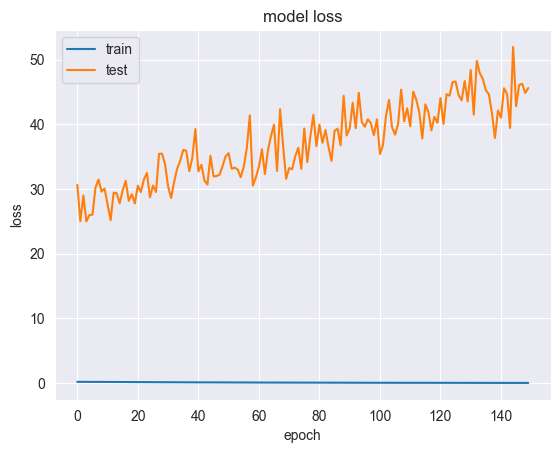

In [268]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [269]:
# Save model and weights
model_name = 'All datasets - Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("All datasets - model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at M:\22-24_CE901-CE911-CF981-SU_olaoye_emmanuel_o\speech_emotion_analyser\saved_models\All datasets - Emotion_Model.h5 


In [270]:
# loading json and model architecture 
json_file = open('All datasets - model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/All datasets - Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = optimizers.RMSprop(learning_rate=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
compile_metrics: 11.52%


In [271]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

420/420 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


array([11,  8,  1, ..., 11, 11, 11], dtype=int64)

In [272]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,male_angry,female_angry
171,female_surprise,female_angry
172,female_surprise,female_angry
173,female_angry,female_sad
174,female_sad,female_happy
175,female_neutral,female_angry
176,male_surprise,female_angry
177,male_anger,female_sad
178,male_surprise,female_sad
179,female_neutral,male_neutral


In [273]:
# Write out the predictions to disk
finaldf.to_csv('All datasets - Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,3196
female_calm,33
female_fearful,94
female_happy,518
female_neutral,6
female_sad,2683
male_angry,5
male_neutral,157
male_suprise,19


In [274]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.11524717093508041


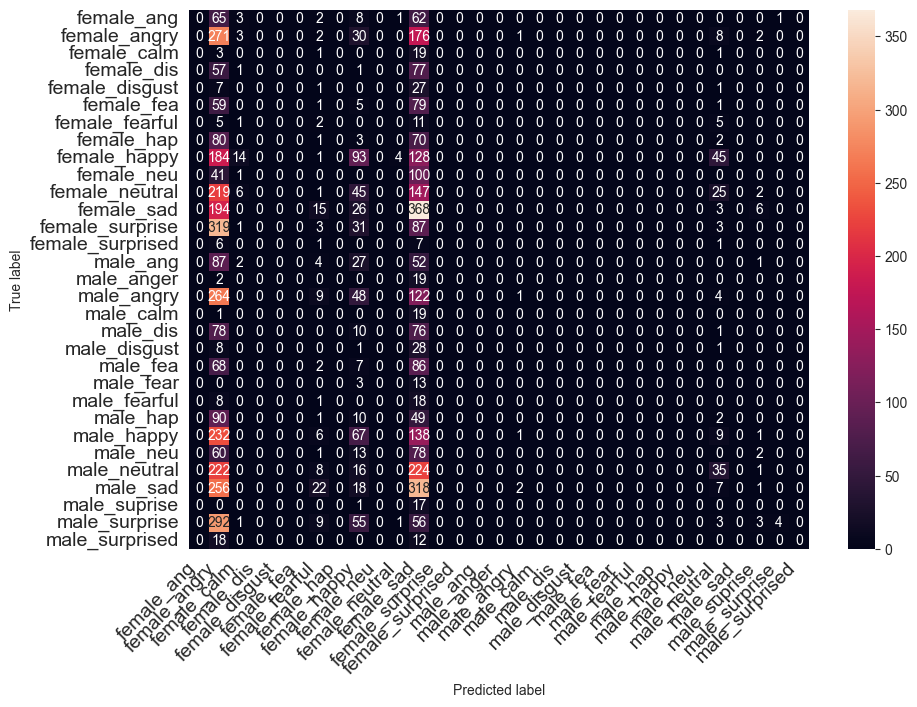

In [275]:
# Get the predictions file 
finaldf = pd.read_csv("All datasets - Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [276]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                  precision    recall  f1-score   support

      female_ang       0.00      0.00      0.00       142
    female_angry       0.08      0.55      0.15       493
     female_calm       0.00      0.00      0.00        24
      female_dis       0.00      0.00      0.00       136
  female_disgust       0.00      0.00      0.00        36
      female_fea       0.00      0.00      0.00       145
  female_fearful       0.02      0.08      0.03        24
      female_hap       0.00      0.00      0.00       156
    female_happy       0.18      0.20      0.19       469
      female_neu       0.00      0.00      0.00       142
  female_neutral       0.00      0.00      0.00       445
      female_sad       0.14      0.60      0.22       612
 female_surprise       0.00      0.00      0.00       444
female_surprised       0.00      0.00      0.00        15
        male_ang       0.00      0.00      0.00       173
      male_anger       0.00      0.00      0.00        21
      male_an

0.21575342465753425


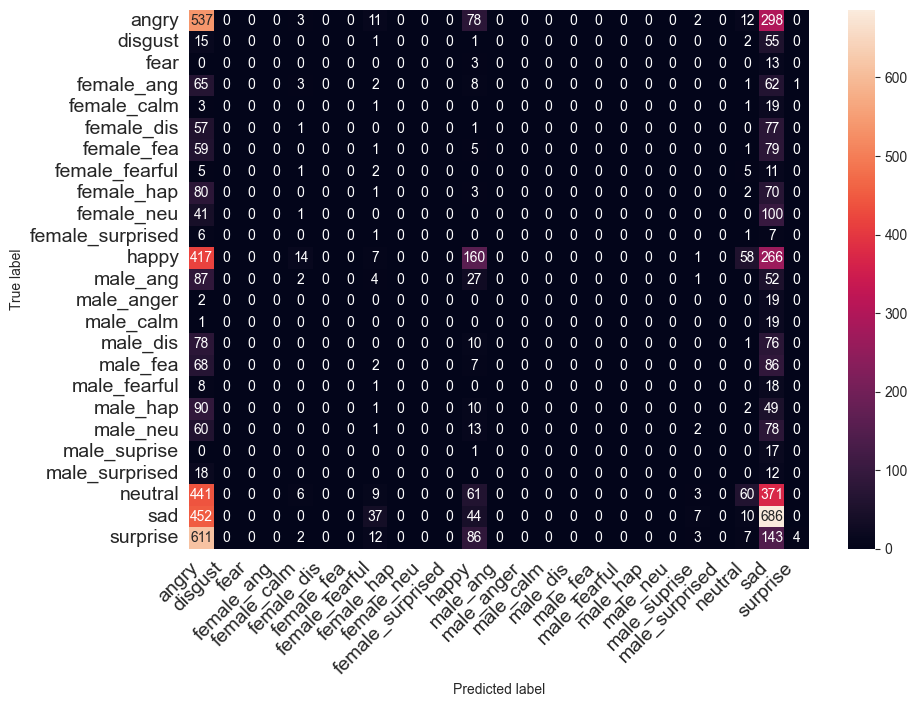

In [277]:
modidf = pd.read_csv("All datasets - Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [278]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

                  precision    recall  f1-score   support

           angry       0.17      0.57      0.26       941
         disgust       0.00      0.00      0.00        74
            fear       0.00      0.00      0.00        16
      female_ang       0.00      0.00      0.00       142
     female_calm       0.00      0.00      0.00        24
      female_dis       0.00      0.00      0.00       136
      female_fea       0.00      0.00      0.00       145
  female_fearful       0.02      0.08      0.03        24
      female_hap       0.00      0.00      0.00       156
      female_neu       0.00      0.00      0.00       142
female_surprised       0.00      0.00      0.00        15
           happy       0.31      0.17      0.22       923
        male_ang       0.00      0.00      0.00       173
      male_anger       0.00      0.00      0.00        21
       male_calm       0.00      0.00      0.00        20
        male_dis       0.00      0.00      0.00       165
        male_